In [1]:
%matplotlib inline


# Resampling data


When performing experiments where timing is critical, a signal with a high
sampling rate is desired. However, having a signal with a much higher sampling
rate than is necessary needlessly consumes memory and slows down computations
operating on the data.

This example downsamples from 600 Hz to 100 Hz. This achieves a 6-fold
reduction in data size, at the cost of an equal loss of temporal resolution.



In [2]:
# Authors: Marijn van Vliet <w.m.vanvliet@gmail.com>
#
# License: BSD (3-clause)

from matplotlib import pyplot as plt

import mne
from mne.datasets import sample

Setting up data paths and loading raw data (skip some data for speed)



In [3]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname).crop(120, 240).load_data()

Opening raw data file C:\Users\jz\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 72074  =      0.000 ...   120.000 secs...


Since downsampling reduces the timing precision of events, we recommend
first extracting epochs and downsampling the Epochs object:



144 events found
Event IDs: [ 1  2  3  4  5 32]
33 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 33 events and 541 original time points ...
0 bad epochs dropped
Original sampling rate: 600.614990234375 Hz
New sampling rate: 100.0 Hz


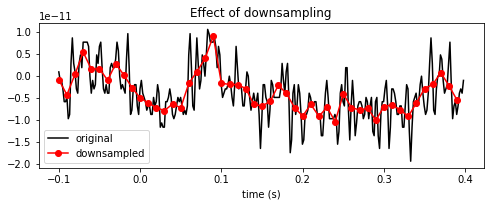

In [8]:
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, event_id=2, tmin=-0.1, tmax=0.8, preload=True)

# Downsample to 100 Hz
print('Original sampling rate:', epochs.info['sfreq'], 'Hz')
epochs_resampled = epochs.copy().resample(100, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')

# Plot a piece of data to see the effects of downsampling
plt.figure(figsize=(7, 3))

n_samples_to_plot = int(0.5 * epochs.info['sfreq'])  # plot 0.5 seconds of data
plt.plot(epochs.times[:n_samples_to_plot],
         epochs.get_data()[0, 0, :n_samples_to_plot], color='black')

n_samples_to_plot = int(0.5 * epochs_resampled.info['sfreq'])
plt.plot(epochs_resampled.times[:n_samples_to_plot],
         epochs_resampled.get_data()[0, 0, :n_samples_to_plot],
         '-o', color='red')

plt.xlabel('time (s)')
plt.legend(['original', 'downsampled'], loc='best')
plt.title('Effect of downsampling')
mne.viz.tight_layout()

When resampling epochs is unwanted or impossible, for example when the data
doesn't fit into memory or your analysis pipeline doesn't involve epochs at
all, the alternative approach is to resample the continuous data. This
can only be done on loaded or pre-loaded data.



In [9]:
# Resample to 300 Hz
raw_resampled = raw.copy().resample(300, npad='auto')

144 events found
Event IDs: [ 1  2  3  4  5 32]
144 events found
Event IDs: [ 1  2  3  4  5 32]


Because resampling also affects the stim channels, some trigger onsets might
be lost in this case. While MNE attempts to downsample the stim channels in
an intelligent manner to avoid this, the recommended approach is to find
events on the original data before downsampling.



In [10]:
print('Number of events before resampling:', len(mne.find_events(raw)))

# Resample to 100 Hz (suppress the warning that would be emitted)
raw_resampled = raw.copy().resample(100, npad='auto', verbose='error')
print('Number of events after resampling:',
      len(mne.find_events(raw_resampled)))

# To avoid losing events, jointly resample the data and event matrix
events = mne.find_events(raw)
raw_resampled, events_resampled = raw.copy().resample(
    100, npad='auto', events=events)
print('Number of events after resampling:', len(events_resampled))

144 events found
Event IDs: [ 1  2  3  4  5 32]
Number of events before resampling: 144
143 events found
Event IDs: [ 1  2  3  4  5 32]
Number of events after resampling: 143
144 events found
Event IDs: [ 1  2  3  4  5 32]
Number of events after resampling: 144


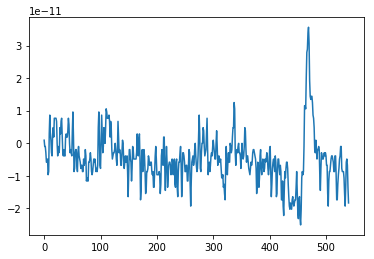

In [30]:
plt.plot(epochs.get_data()[0][0])

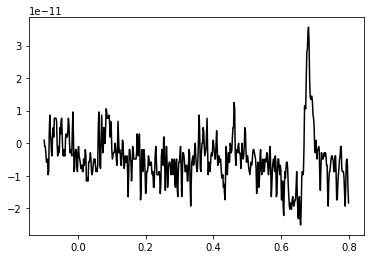

In [31]:
plt.plot(epochs.times,
         epochs.get_data()[0, 0], color='black')

In [35]:
dict(epochs.info)

{'file_id': {'version': 65537,
  'machid': array([   1082367, 1060765696]),
  'secs': 1038942072,
  'usecs': 190548},
 'events': [{'channels': array([307, 308, 309, 310, 311, 312, 313, 314, 315]),
   'list': array([ 16422,      0,     64, ..., 168680,     32,      0])}],
 'hpi_results': [{'dig_points': [{'kind': 2,
     'ident': 1,
     'r': array([-0.05793186,  0.06880924,  0.0233194 ], dtype=float32),
     'coord_frame': 0},
    {'kind': 2,
     'ident': 2,
     'r': array([ 0.06629638, -0.01940589,  0.04533793], dtype=float32),
     'coord_frame': 0},
    {'kind': 2,
     'ident': 3,
     'r': array([-0.0644714 , -0.0248894 ,  0.03658791], dtype=float32),
     'coord_frame': 0},
    {'kind': 2,
     'ident': 4,
     'r': array([0.04672292, 0.09406918, 0.02635559], dtype=float32),
     'coord_frame': 0}],
   'order': array([2, 4, 3, 1]),
   'used': array([1, 3, 4]),
   'moments': array([[ 6.1415781e-16, -4.4084653e-16, -5.7963942e-16],
          [-6.0518641e-16,  3.3969915e-16, -5.41